In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

if "/home/coberndorm/Documents/Semestre_IX/Artificial_Intelligence" not in sys.path:
  sys.path.append("/home/coberndorm/Documents/Semestre_IX/Artificial_Intelligence/")

In [2]:
import MLP.preprocessing as dm
import MLP.plottingFunctions as pltf
import MLP.clustering as clt
import MLP.normas as nm

Getting the Iris dataset

In [3]:
from sklearn.datasets import load_iris

iris= load_iris()
data = iris.data

# Normalize data
data = dm.normalize_min_max(data)
data = data[:,0:4]

## Mountain Clustering

In [4]:
def mountain_cluster_centers(data, grid = None, alpha = None, beta = None, epsilon = 0.1):
    
    dim = data.shape[1]
    n = np.floor(len(data)**(1/dim))

    if alpha == None:
        radius = 1/(n-1)
        alpha = 4/(radius**2)
        beta = 4/((radius*1.25)**2)

    dim = data.shape[1]
    n = np.floor(len(data)**(1/dim))

    if grid == None:
        grid = clt.generate_grid_vertices(dim, int(n), 0, 1)
    
    centers = []
    mountain_values = []
    grid = np.array(grid)

    for vertex in grid:
        mountain_values.append(np.sum(np.exp(-(np.linalg.norm(data - vertex, axis=1)**2)/(2*alpha**2))))
        
    max_mountain = np.argmax(mountain_values)

    while True:
        
        max_mountain = np.argmax(mountain_values)
        p_u = grid[max_mountain]
        max_vertex = grid[max_mountain]

        centers.append(max_mountain)
        
        mountain_val_new = []

        for i,vertex in enumerate(grid):
            mountain_val_new.append(mountain_values[i] - mountain_values[max_mountain] * (np.exp(-(np.linalg.norm(np.array(vertex) - np.array(max_vertex))**2)/(2*beta**2))))
        
        if np.max(mountain_val_new) < epsilon * mountain_values[max_mountain]:
            break

        mountain_values = mountain_val_new
    
    return centers


def mountain_clusters(data, alpha = 0.5, centers = None, grid = None, method = "density"):

    assert method in ["density", "distance"], "Method must be either 'density' or 'distance'"

    if centers == None:
        dim = data.shape[1]
        n = np.floor(len(data)**(1/dim))
        grid = clt.generate_grid_vertices(dim, int(n), 0, 1)
        centers = mountain_cluster_centers(data, grid = grid)

    clusters = []
    grid = np.array(grid)

    if method == "density":
        for point in data:
            density = [np.exp(-(np.linalg.norm(np.array(point) - np.array(vertex))**2)/(2*alpha**2)) for vertex in grid[centers]]
            clusters.append(np.argmax(density))

    elif method == "distance":
        clusters = []
        
        for point in data:
            min_dist = np.inf
            min_center = None
            for i,center in enumerate(centers):
                dist = np.linalg.norm(point - center)
                if dist < min_dist:
                    min_dist = dist
                    min_center = i
            clusters.append(min_center)
    
    return clusters

In [5]:
dim = data.shape[1]
n = np.floor(len(data)**(1/dim))
grid = clt.generate_grid_vertices(dim, int(n), 0, 1)

alpha = 0.4
beta = 1.45*alpha


centers = mountain_cluster_centers(data, grid=grid, alpha = alpha, beta =  beta, epsilon = 0.2)
clusters = mountain_clusters(data, alpha=alpha, centers=centers, grid=grid, method="density")

In [6]:
set(clusters)

{0, 1, 2}

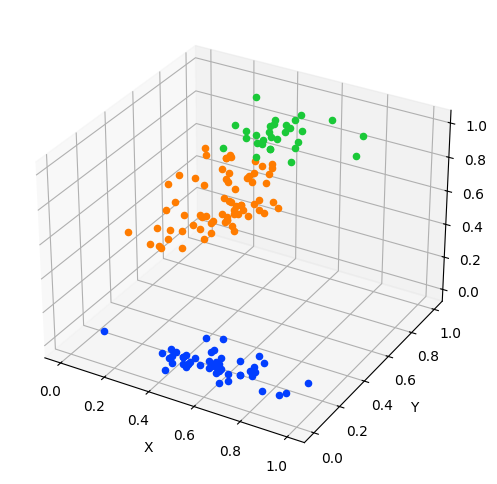

In [7]:
clusters_ = {cluster:[x for x in range(len(clusters)) if clusters[x] == cluster] for i,cluster in enumerate(clusters)}
pltf.plot_data_by_clusters_3d(data, clusters_, axis=[1,2,3], palette="bright")

## Substractive cluster

In [8]:
import numpy as np

def substractive_cluster_centers(data, radius_a=None, radius_b=None, epsilon=0.1):
    if radius_a is None:
        n = int(np.floor(len(data) ** (1 / data.shape[1])))
        radius = 1 / (n - 1)
        radius_a = 4 / (radius ** 2)
        radius_b = 4 / ((radius * 1.45) ** 2)

    centers = []
    influence = []

    for point in data:
        distance = np.linalg.norm(data - point, axis=1)
        influence.append(np.sum(np.exp(-distance ** 2 / (radius_a / 2) ** 2)))

    while True:
        max_influence = np.argmax(influence)
        p_u = data[max_influence]
        max_vertex = data[max_influence]
        centers.append(max_influence)
        mountain_val_new = []

        for i, point in enumerate(data):
            distance = np.linalg.norm(np.array(point) - np.array(max_vertex))
            mountain_val_new.append(influence[i] - influence[max_influence] * (np.exp(-distance ** 2 / (radius_b / 2) ** 2)))

        if np.max(mountain_val_new) < epsilon * influence[max_influence]:
            break

        influence = mountain_val_new

    return centers

def substractive_mountain_clusters(data, centers=None, radius_a=0.5, method="density"):
    assert method in ["density", "distance"], "Method must be either 'density' or 'distance'"

    if centers is None:
        centers = substractive_cluster_centers(data)

    clusters = []

    for point in data:
        if method == "density":
            density = [np.exp(-(np.linalg.norm(np.array(point) - np.array(data[center]))**2)/(radius_a**2)) for center in centers]
            clusters.append(np.argmax(density))


        elif method == "distance":
            min_dist = np.inf
            min_center = None
            for i, center in enumerate(centers):
                dist = np.linalg.norm(point - data[center])
                if dist < min_dist:
                    min_dist = dist
                    min_center = i
            clusters.append(min_center)

    return clusters


In [9]:
alpha = 0.55
beta = 1.45*alpha


centers = substractive_cluster_centers(data, radius_a = alpha, radius_b =  beta, epsilon = 0.2)
clusters = substractive_mountain_clusters(data, centers=centers, radius_a=alpha, method="density")

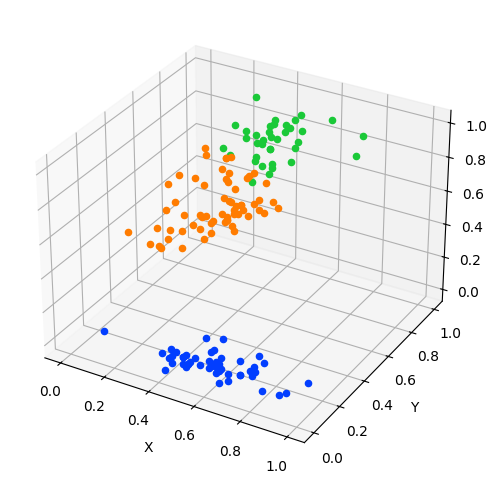

In [10]:
clusters_ = {cluster:[x for x in range(len(clusters)) if clusters[x] == cluster] for i,cluster in enumerate(clusters)}
pltf.plot_data_by_clusters_3d(data, clusters_, axis=[1,2,3], palette="bright")

## K means clustering

In [11]:
def k_means_clusters(data, k, centers = None, epsilon = 0.1):

    assert k > 0, "k must be greater than 0"

    if centers == None:
        centers = np.random.choice(len(data), k, replace=False)

    print(centers)
    
    cost_function = 1000
    
    while True:
        #define distance matrix
        dist = nm.distance_matrix(data, data[centers,:])

        #define Membership matrix
        U = np.argmin(dist, axis=1)
        
        dist_to_centers = np.min(dist, axis=1)
        cost_function_new = np.sum(dist_to_centers)
        
        #stop criteria is the change in the cost function is less than epsilon
        if cost_function - cost_function_new < epsilon:
            break

        #define new centers
        for i in range(k):
            centers[i] = np.mean(data[U == i], axis=0)

        #update cost function
        cost_function = cost_function_new

    return U, centers




In [12]:
k_means_clusters(data, 3)

[14 88 69]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [14]:
np.array([1,2,3,2]) != None

array([ True,  True,  True,  True])